In [1]:
import pickle
import tqdm
from astropy.table import Table
from random import sample, shuffle

from NoiseSOM import *
from pipeline_tools import *

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import multiprocess as mp

# Simulating Wide-Field Galaxies

In order to create a mapping between the deep-field redshift map and the wide-field SOM, we need to know where the deep-field galaxies would be (statistically speaking) on the wide-field map. This means we need to take (~ noiseless) deep-field fluxes and make noisy realizations and map those onto the wide-field cells. Once we have these noise realizations, we will have everything we need to make a wide-cell-to-redshift map.

BFD fluxes have (in theory) gaussian error. So, we will generate gaussian noise on deep-field fluxes with a distribution width drawn from average covariances in parts of the DES footprint.

## Data Loading

In [2]:
with open('../data/covariances/BFD_covariances_masked.pkl', 'rb') as f:
    covariances = pickle.load(f)
    
cat = Table.read('../data/deep_field_data/BFD/VALIDATE_CAT_1E+05.fits')
wideres = 32
deepres = 64

In [3]:
# load trained SOMs
out_path = '../outputs/%s'

SOMs_filenames = {
    "DES deep": "%s/SOM.pkl"%(out_path%'BFD_deep/'), 
    "DES wide": "%s/SOM.pkl"%(out_path%'BFD/'), 
}

SOMs = {key: load_SOM(SOMs_filenames[key]) for key in SOMs_filenames}

In [4]:
# load deep assignments

filename = "../outputs/BFD_deep/assignments.pkl"
with open(filename, 'rb') as f:
    fdata = pickle.load(f) ; assignments = []
    for a in fdata:
        assignments = np.append(assignments, a)
    cat["assigned DES deep"] = assignments
    
print([key for key in cat.colnames if "assign" in key])

['assigned DES deep']


# Deep to Wide Mapping

In [5]:
nonzero_mask = np.array(covariances.nonzero()[1])
noise_options = covariances.A[:,nonzero_mask]
noise_options_idcs = np.where(nonzero_mask)
n_realizations = 100

In [6]:
def map_to_wide(i):
    
    template_fluxes = cat['BFD_fluxes_ugriz'][i][1:]
    
    idcs = np.array(sample(range(noise_options.shape[1]), n_realizations)) 
    wide_fluxes_err = np.array([np.sqrt(noise_options[i, idcs]) for i in range(noise_options.shape[0])]).T
    wide_fluxes = np.array([[np.random.normal(f, ferr[j]) for j,f in enumerate(template_fluxes)]
                            for ferr in wide_fluxes_err])
        
    min_SN = 7 ; max_SN=200
    SN_ = SN(wide_fluxes,wide_fluxes_err)
    mask = (SN_>min_SN) & (SN_<max_SN)
    wide_fluxes = wide_fluxes[mask]
    wide_fluxes_err = wide_fluxes_err[mask]
    
    cells, _ = SOMs['DES wide'].classify(wide_fluxes, wide_fluxes_err)
        
    result = {}
    result['deep position'] = cat['assigned DES deep'][i]
    result['wide positions'] = cells
    result['z'] = cat['COSMOS_PHOTZ'][i]
    
    result['wide fluxes'] = wide_fluxes
    result['wide errors'] = wide_fluxes_err
    result['healpix pos'] = noise_options[:,idcs] 
    
    result['id'] = cat['id_array'][i]
    
    return result

In [7]:
fname = '../outputs/mock_assignments/simulations.pkl'
if not os.path.exists(fname):
    args = [(i,) for i in range(len(cat['id_array']))]
    p = mp.Pool(5) 
    
    num_inds = len(cat['id_array'])
    results = list(tqdm.tqdm(p.imap(map_to_wide, range(num_inds)), total=num_inds))
    
    d = {key: [] for key in results[0]}
    for r in results:
        for key in d:
            d[key] += [r[key]]
    
    with open(fname, 'wb') as f:
        pickle.dump(d, f)
else:
    with open(fname, 'rb') as f:
        d = pickle.load(f)


deep_positions = d['deep position']
wide_positions = d['wide positions']
wide_fluxes = d['wide fluxes']
wide_errs = d['wide errors']
redshifts = d['z']

  0%|                                    | 182/100000 [00:13<1:58:07, 14.08it/s]/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:18: RuntimeWarning: invalid value encountered in true_divide
  return signal/noise
  0%|                                    | 208/100000 [00:15<2:10:20, 12.76it/s]/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:18: RuntimeWarning: invalid value encountered in true_divide
  return signal/noise
  0%|                                    | 233/100000 [00:16<1:55:36, 14.38it/s]/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:18: RuntimeWarning: invalid value encountered in true_divide
  return signal/noise
  0%|                                    | 249/100000 [00:18<2:02:13, 13.60it/s]/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:18: RuntimeWarning: invalid value encountered in true_divide
  return signal/noise
  0%|                                    | 320/100000 [00:23<1:45:05, 15.81it/s]

# Data Checking

- Make a mock catalog (first noise realization for each deep field galaxy)
- Make sure the generated data looks similar to the actual BFD measurements
- Make sure the colors/SN distributions make sense

In [8]:
mock_cat = {
    'positions': np.array([p for p in wide_positions]),
    'fluxes': np.array([f[5] for f in wide_fluxes if len(f)>5]),
    'fluxes_err': np.array([fe[5] for fe in wide_errs if len(fe)>5])
}

data_path = '../data/wide_field_data/BFD/VALIDATION_CAT_1E+05.fits'
d = Table.read(data_path, format='fits')
    
data_path = '../data/deep_field_data/BFD/VALIDATE_CAT_1E+05.fits'
d_deep = Table.read(data_path, format='fits')
    
d['BFD_deep'] = [(f[1],f[2],f[3],f[4]) for f in d_deep['BFD_fluxes_ugriz']]

/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_16656/3260751034.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'positions': np.array([p for p in wide_positions]),


In [9]:
def flux_to_mag(f, const=30):
    return -2.5 * np.log10(f) + const

/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_16656/3030764557.py:2: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f) + const
/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_16656/3030764557.py:2: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(f) + const


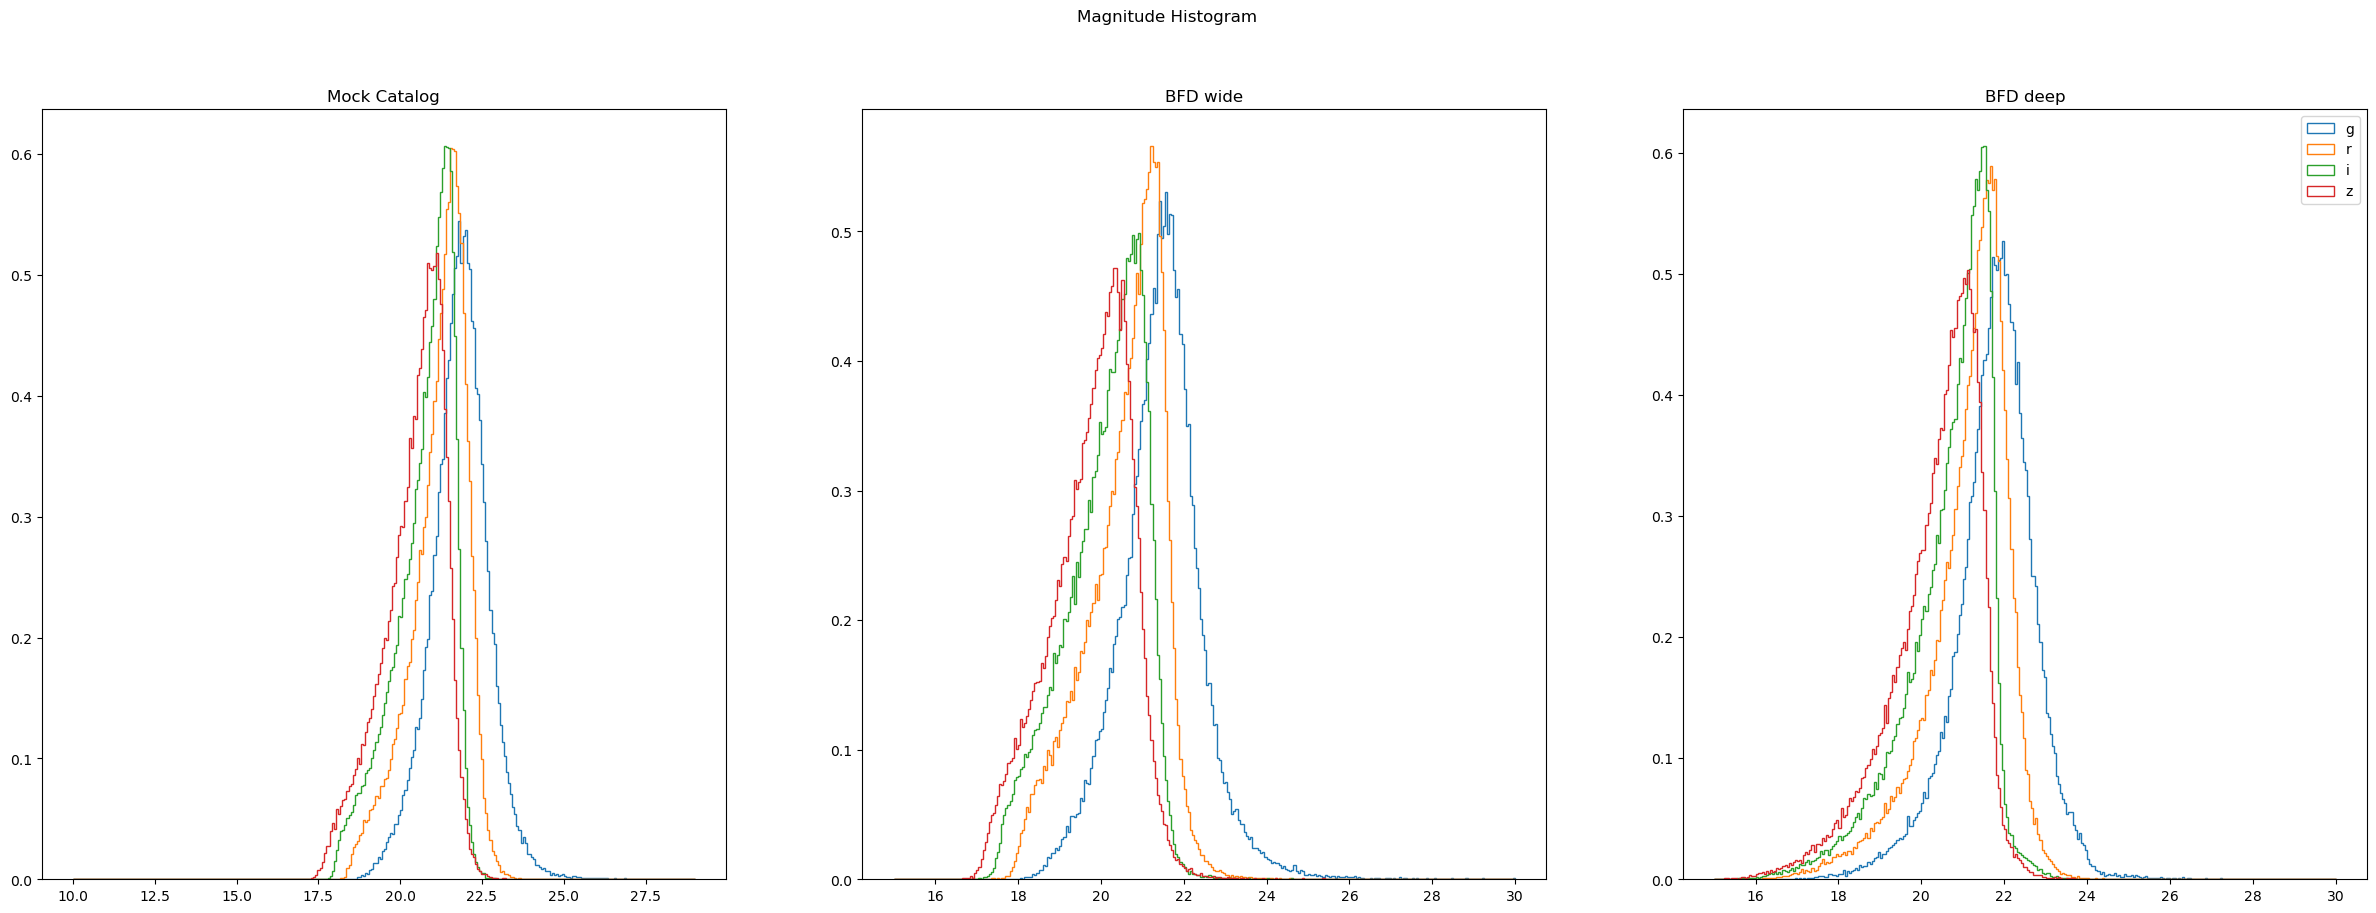

In [10]:
const = 30

mag_mock = flux_to_mag(mock_cat['fluxes'], const)
mag_bfd_wide = flux_to_mag(d['Mf_per_band'], const)
mag_bfd_deep = flux_to_mag(d['BFD_deep'], const)

mags = {key: [np.array([m[i] for m in mag_mock]), 
              np.array([m[i] for m in mag_bfd_wide]),
              np.array([m[i] for m in mag_bfd_deep])]
         for i,key in enumerate(['g', 'r', 'i', 'z'])}

fig, axs = plt.subplots(1,3,figsize=(30, 10))

ranges = [(10, 29), (15, 30), (15,30)]
for i, ax in enumerate(axs):
    for band in mags:
        ax.hist(mags[band][i], 300, range=ranges[i], histtype='step', label=band, density=True)

plt.legend()
plt.suptitle("Magnitude Histogram")
axs[0].set_title("Mock Catalog") ; axs[1].set_title("BFD wide"); axs[2].set_title("BFD deep") 
plt.show()

/var/folders/nt/7hp8jjq563b09vy01vqx17dh0000gn/T/ipykernel_16656/1773212272.py:11: RuntimeWarning: invalid value encountered in subtract
  bfd_deep_diff = mags[b1][2] - mags[b2][2]
/Users/danecross/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


100000 97798
100000 97874
g-r
Wide Mock: 0.64 $\pm$ 0.49
BFD Wide: 0.79 $\pm$ nan
BFD Deep: 0.57 $\pm$ 0.49
100000 98611
100000 98043
r-i
Wide Mock: 0.46 $\pm$ 0.34
BFD Wide: 0.46 $\pm$ 0.38
BFD Deep: 0.41 $\pm$ 0.32
100000 98509
100000 98047
i-z
Wide Mock: 0.32 $\pm$ 0.29
BFD Wide: 0.32 $\pm$ 0.35
BFD Deep: 0.29 $\pm$ 0.26


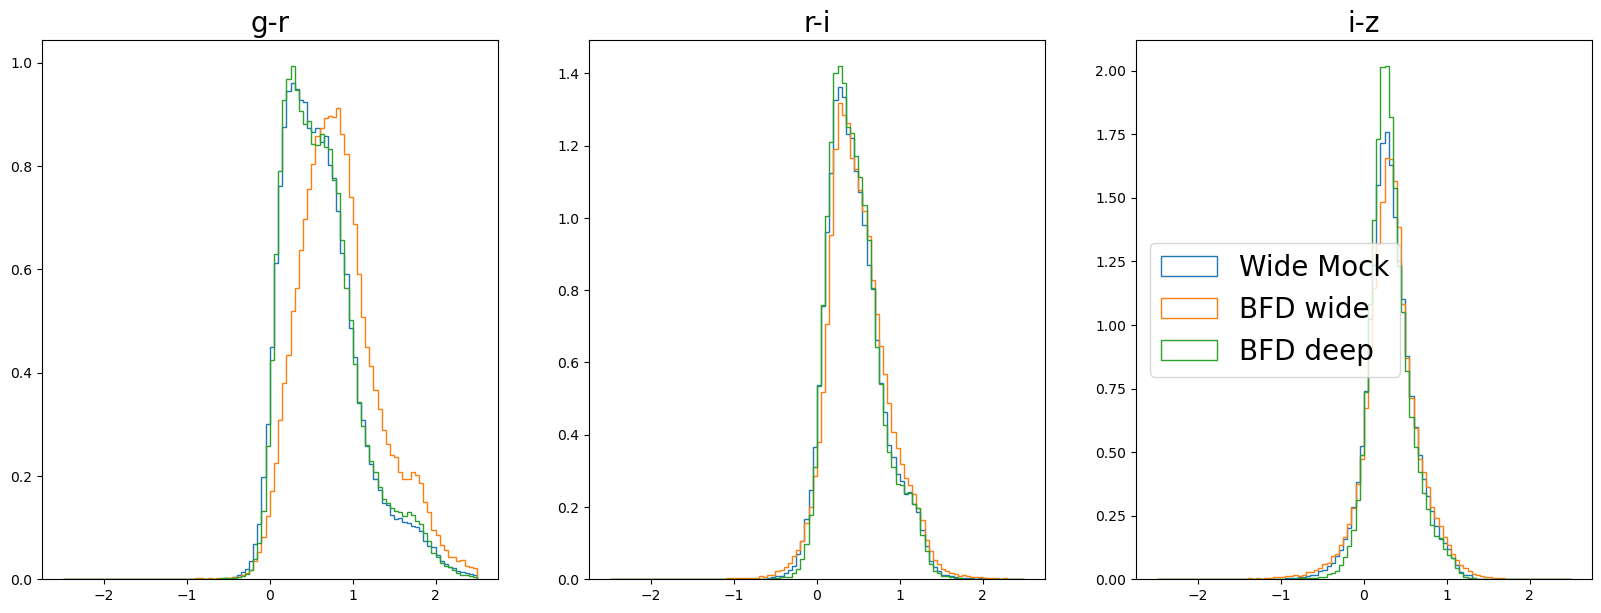

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20,7))

r = (-2.5, 2.5)
for i, b1, b2 in zip(range(5), ['g', 'r', 'i', 'z'], ['r', 'i', 'z']):
    mock_diff = mags[b1][0] - mags[b2][0] 
    axs[i].hist(mock_diff, 100, range=r, histtype='step', label="Wide Mock", density=True)
    
    bfd_wide_diff = mags[b1][1] - mags[b2][1]
    axs[i].hist(bfd_wide_diff, 100, range=r, histtype='step', label="BFD wide", density=True)
    
    bfd_deep_diff = mags[b1][2] - mags[b2][2]
    axs[i].hist(bfd_deep_diff, 100, range=r, histtype='step', label="BFD deep", density=True)

    print(len(bfd_wide_diff), len(bfd_wide_diff[~np.isnan(bfd_wide_diff)]))
    print(len(bfd_deep_diff), len(bfd_wide_diff[~np.isnan(bfd_deep_diff)]))
    
    axs[i].set_title('%s-%s'%(b1,b2), fontsize=20)
    print('%s-%s'%(b1,b2))
    print(r'Wide Mock: %.02f $\pm$ %.02f'%(np.nanmean(mock_diff), np.nanstd(mock_diff),))
    print(r'BFD Wide: %.02f $\pm$ %.02f'%(np.nanmedian(bfd_wide_diff), np.nanstd(bfd_wide_diff)))
    print(r'BFD Deep: %.02f $\pm$ %.02f'%(np.nanmedian(bfd_deep_diff), np.nanstd(bfd_deep_diff)))

axs[-1].legend(fontsize=20)
plt.show()

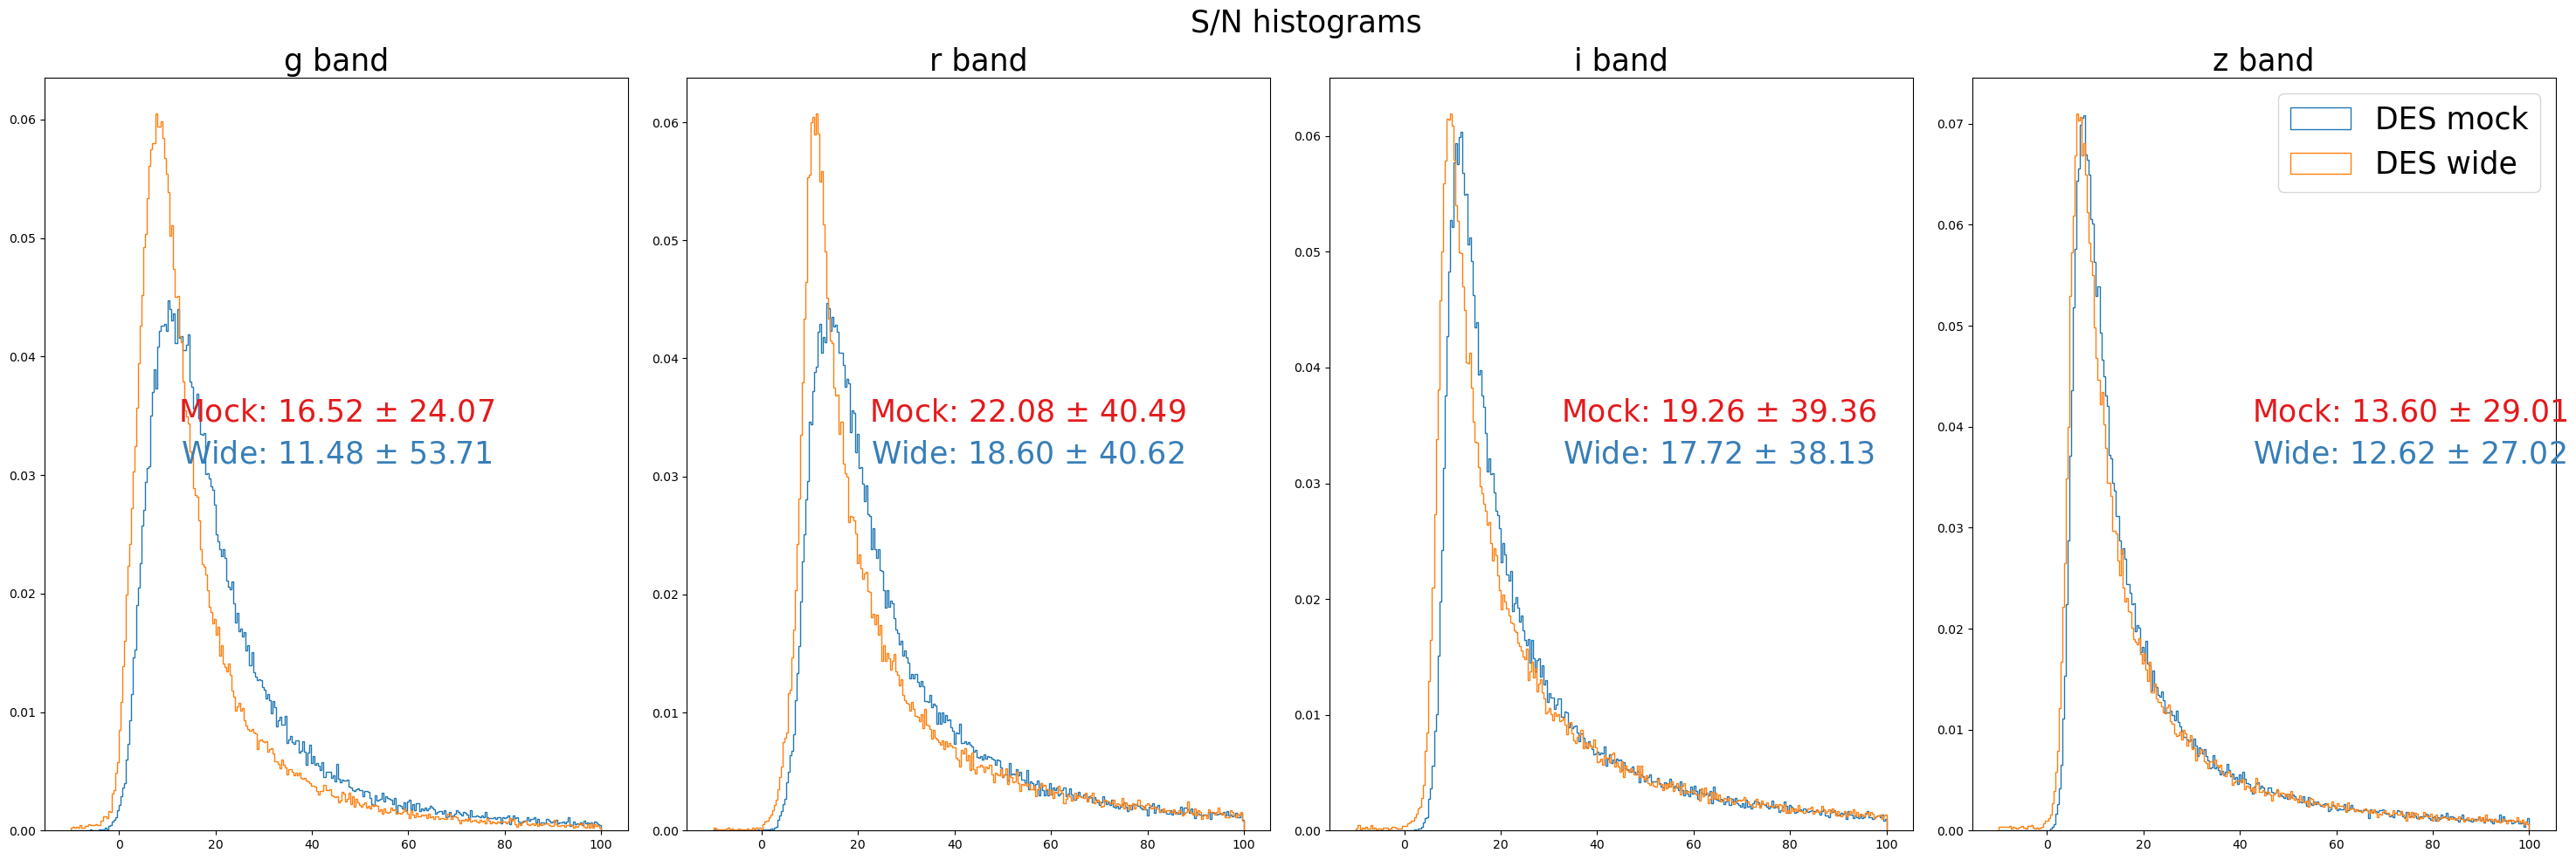

In [19]:
SN_mock = mock_cat['fluxes']/mock_cat['fluxes_err']
SN_desd = d['Mf_per_band']/np.sqrt(d['cov_Mf_per_band'])

fig, axs = plt.subplots(1,4,figsize=(30,10))
titles = ['g band', 'r band', 'i band', 'z band']
r=(-10,100)
for i, ax in enumerate(axs):
    mock_f = [sn[i] for sn in SN_mock]
    ax.hist(mock_f, 300, range=r, histtype='step', label='DES mock', density=True)
    
    desd_f = [sn[i] for sn in SN_desd]
    h = ax.hist(desd_f, 300, range=r, histtype='step', label='DES wide', density=True)
    ax.set_title(titles[i], fontsize=25)
    
    axs[i].text(0.5+i/12, 0.556,  
                r'Mock: %.02f $\pm$ %.02f'%(np.nanmedian(mock_f), np.nanstd(mock_f)),
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
                color=plt.cm.Set1(0), fontsize=25)
    
    axs[i].text(0.5+i/12, 0.5,  
                r'Wide: %.02f $\pm$ %.02f'%(np.nanmedian(desd_f), np.nanstd(desd_f)),
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,
                color=plt.cm.Set1(1), fontsize=25)
    
plt.suptitle("S/N histograms", fontsize=25)
plt.legend(fontsize=25)
fig.tight_layout()
plt.show()

## Deep to Wide Maps

Looks good, now we're going to show some samples of how adding noise to the wide galaxies changes the mapping from the deep SOM to the wide SOM

In [13]:
def avg_SN(fluxes, fluxes_err):
    SNs = []
    for f, fe in zip(fluxes, fluxes_err):
        g,r,i,z = f
        ge, re, ie, ze = fe
        signal = (0.7 * r**2 + 0.2 * i**2 + 0.1 * z**2)
        noise = (0.7 * re**2 + 0.2 * ie**2 + 0.1 * ze**2)
        SNs += [np.sqrt(signal/noise)]
    return np.nanmean(SNs)

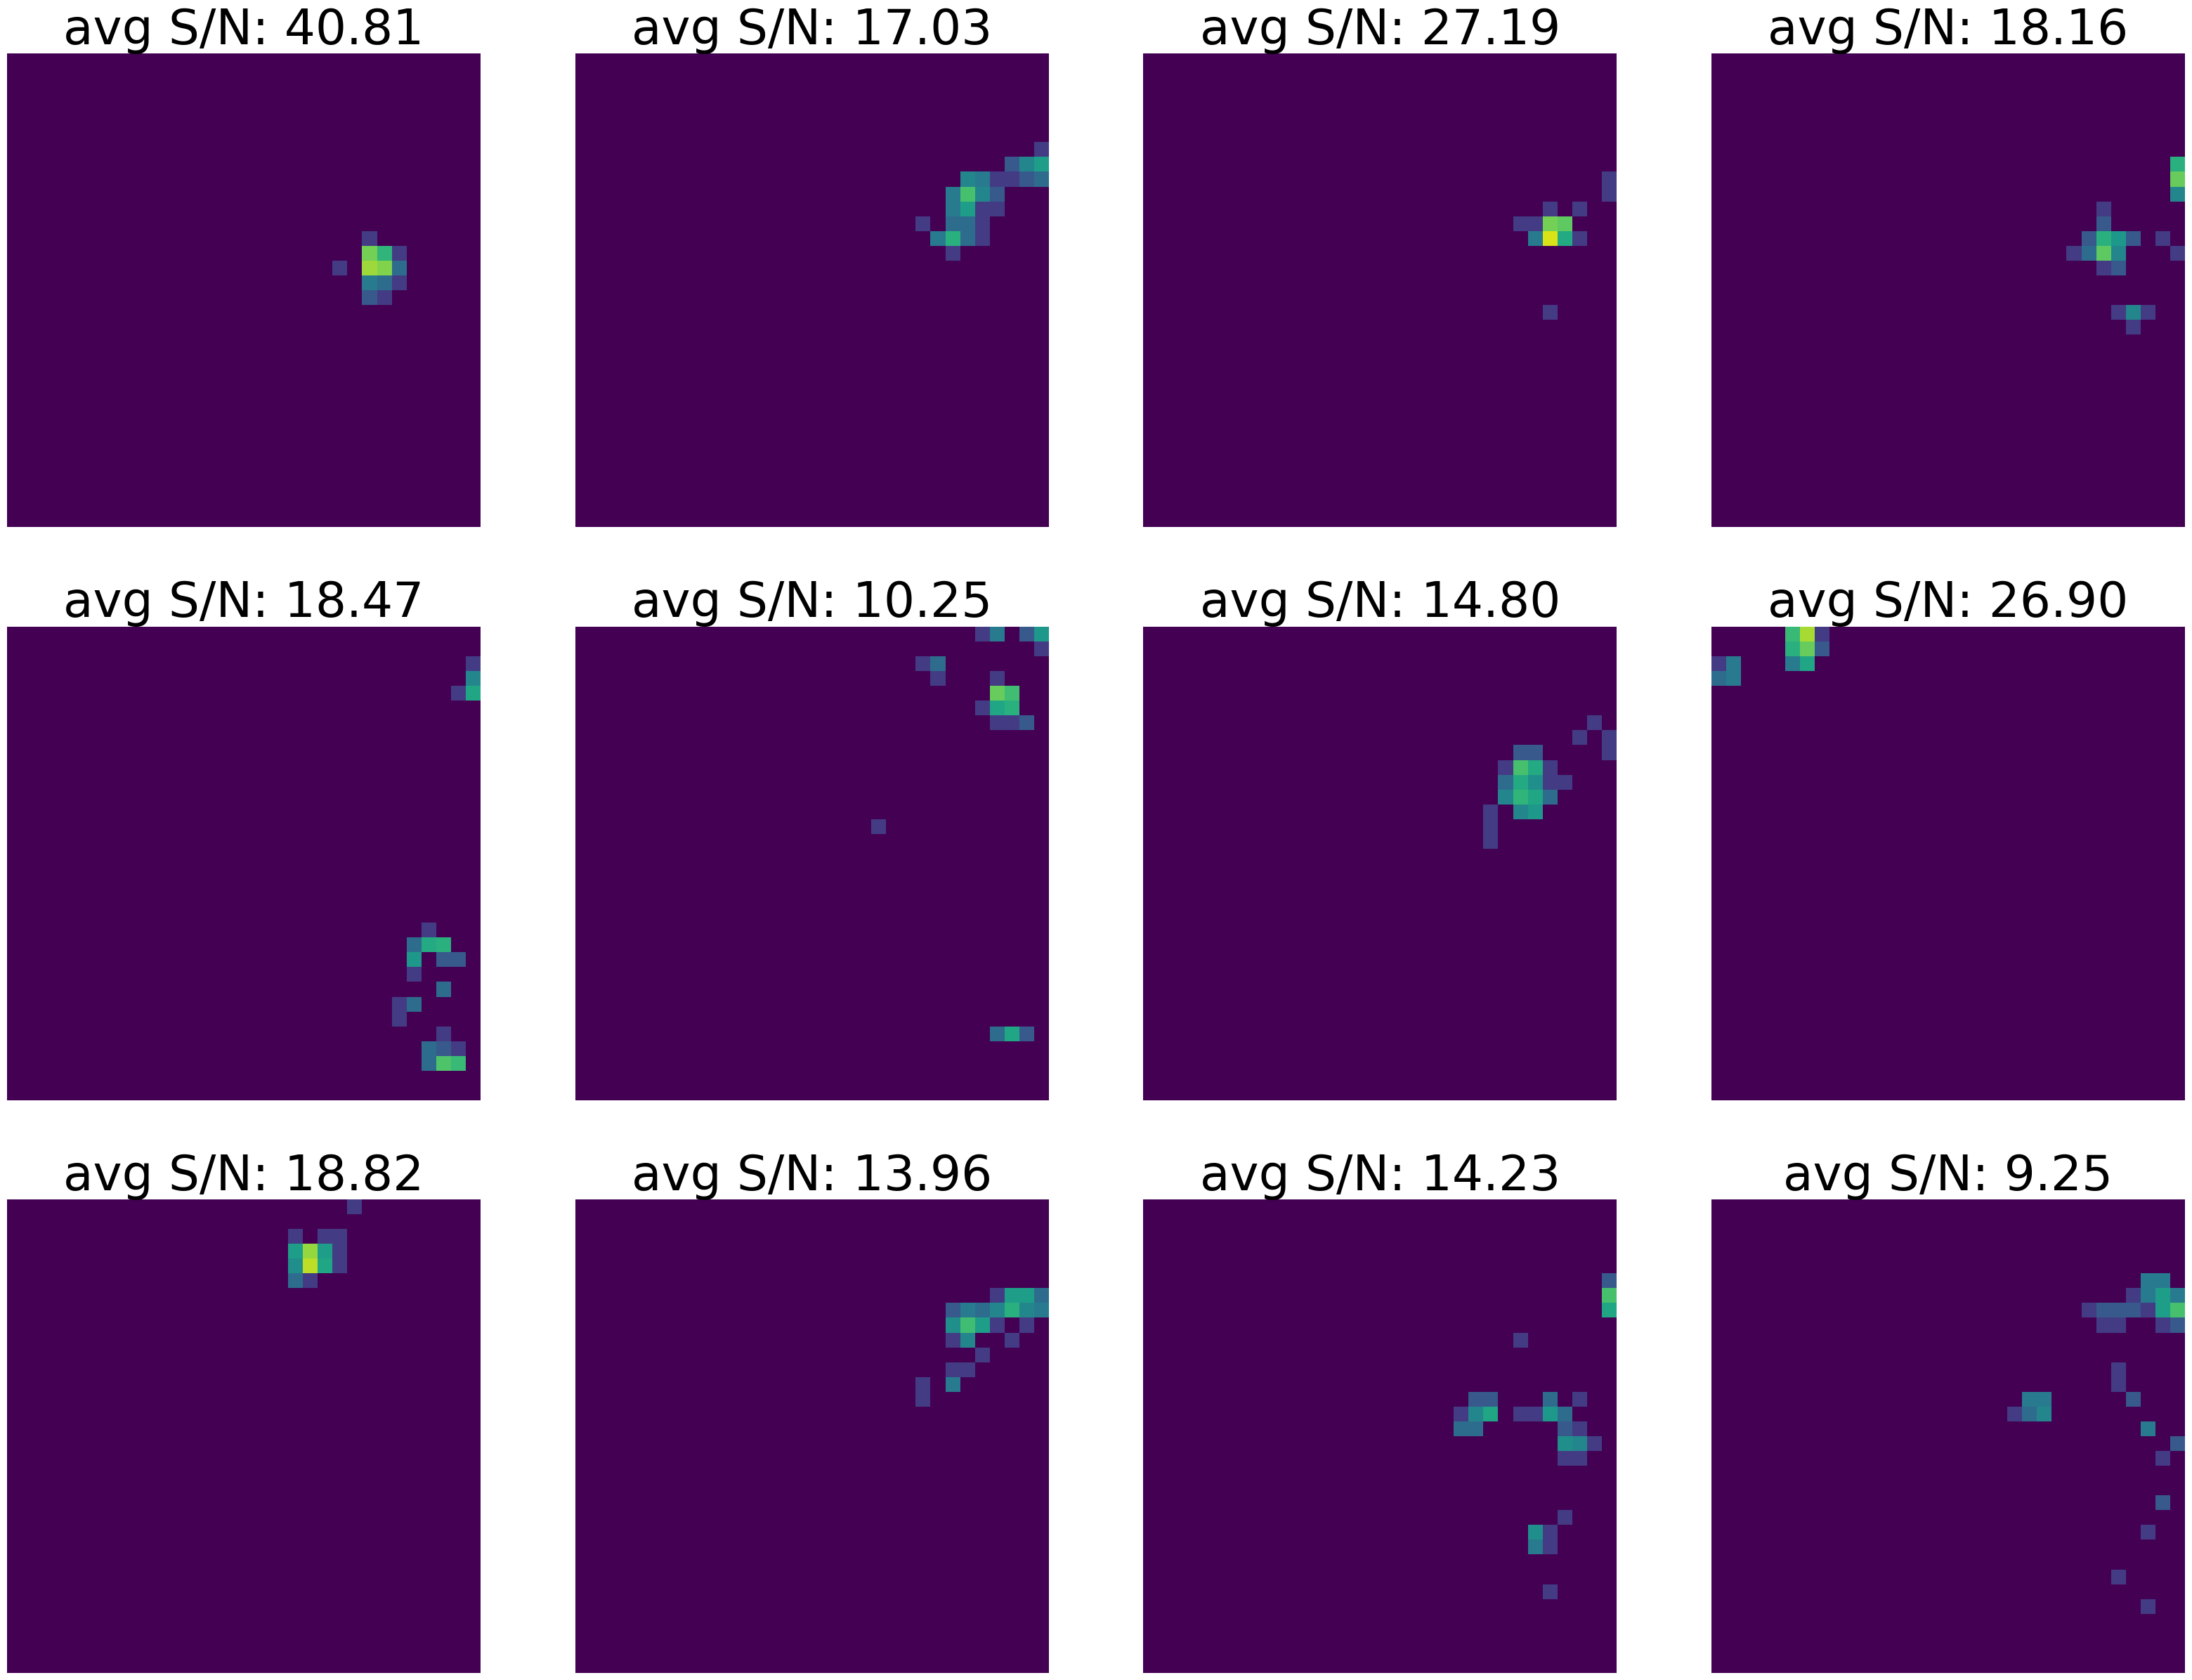

In [14]:
fig, axs = plt.subplots(3,4, figsize=(40,30))
_max = -np.inf ; _min = np.inf

nonempty_wp = [wps for wps in wide_positions if len(wps)>0]
nonempty_f = [f for f,wps in zip(wide_fluxes,wide_positions) if len(wps)>0]
nonempty_fe = [fe for fe,wps in zip(wide_errs,wide_positions) if len(wps)>0]
for i,poss in enumerate(nonempty_wp):
    if i >= 12: break
    _max = max(_max, np.max(poss[0]))
    _min = min(_min, np.min(poss[0]))
    wide_occupation = np.histogram(poss,bins=wideres*wideres, range=(0,wideres*wideres))[0].reshape((wideres,wideres))
    im = axs[i//4,i%4].imshow(1+wide_occupation, norm=LogNorm(vmin=1, vmax=50,))
    
    #divider = make_axes_locatable(axs[i%3,i//4])
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    #fig.colorbar(im, cax=cax, orientation='vertical')
    
    SN = avg_SN(nonempty_f[i], nonempty_fe[i])
    axs[i//4,i%4].set_title("avg S/N: %.02f"%SN, fontsize=50)
    axs[i//4,i%4].axis('off')
    
    
plt.show()